In [70]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal
import pymer4.models
import scipy.stats
import os
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint
import matplotlib.pyplot as plt

In [37]:
def simulate_merging_data_stratified_bootstrap_random_effects(
    empirical_data,
    n_participants=24,
    trials_per_condition=30,
    seed=42
):
    np.random.seed(seed)
    
    random_effect_sds={'d': 0.56, 'tta': 0.74, 'time_budget': 0.33}

    coefs = {
        'intercept': 1.77,
        'distance': 0.51,
        'TTA': 2.24,
        'time_budget': -0.28,
        'dwell_mirror': -0.32,
        'RT': -1.97,
        'distance:dwell_mirror': -0.15,
        'TTA:dwell_mirror': 0.13,
        'time_budget:dwell_mirror': 0.24,
    }

    condition_grid = pd.DataFrame([
        (tta, d, tb)
        for tta in [4, 6]
        for d in [20, 30, 40]
        for tb in [4, 6]
    ], columns=['tta', 'd', 'time_budget'])

    trial_list = []

    # Generate participant-level random slopes (z-scaled)
    random_effects = pd.DataFrame({
        'participant': range(n_participants),
        'd_re': np.random.normal(0, random_effect_sds['d'], n_participants),
        'tta_re': np.random.normal(0, random_effect_sds['tta'], n_participants),
        'time_budget_re': np.random.normal(0, random_effect_sds['time_budget'], n_participants),
    })

    for pid in range(n_participants):
        d_re = random_effects.loc[pid, 'd_re']
        tta_re = random_effects.loc[pid, 'tta_re']
        tb_re = random_effects.loc[pid, 'time_budget_re']

        for _ in range(trials_per_condition):
            for _, cond in condition_grid.iterrows():
                tta, d, tb = cond['tta'], cond['d'], cond['time_budget']
                matching = empirical_data[
                    (empirical_data['tta'] == tta) &
                    (empirical_data['d'] == d) &
                    (empirical_data['time_budget'] == tb)
                ]
                if matching.empty:
                    raise ValueError(f"No empirical data for condition: TTA={tta}, d={d}, time_budget={tb}")
                sample = matching.sample(n=1, replace=True, random_state=np.random.randint(0, 1e6)).iloc[0]
                trial_list.append({
                    'participant': pid,
                    'tta': tta,
                    'd': d,
                    'time_budget': tb,
                    'dwell_mirror': sample['dwell_mirror'],
                    'RT': sample['RT'],
                    'd_re': d_re,
                    'tta_re': tta_re,
                    'time_budget_re': tb_re
                })

    df = pd.DataFrame(trial_list)
    df['trial'] = df.groupby('participant').cumcount()

    # Z-score predictors
    z_vars = ['d', 'tta', 'time_budget', 'dwell_mirror', 'RT']
    df_z = df[z_vars].apply(lambda x: (x - x.mean()) / x.std())
    for var in z_vars:
        df[f"{var}_z"] = df_z[var]

    # Interaction terms
    df['d_dwell_z'] = df['d_z'] * df['dwell_mirror_z']
    df['tta_dwell_z'] = df['tta_z'] * df['dwell_mirror_z']
    df['time_budget_dwell_z'] = df['time_budget_z'] * df['dwell_mirror_z']

    # Logistic model with random slopes for z-scored predictors
    logit = (
        coefs['intercept']
        + (coefs['distance'] + df['d_re']) * df['d_z']
        + (coefs['TTA'] + df['tta_re']) * df['tta_z']
        + (coefs['time_budget'] + df['time_budget_re']) * df['time_budget_z']
        + coefs['dwell_mirror'] * df['dwell_mirror_z']
        + coefs['RT'] * df['RT_z']
        + coefs['distance:dwell_mirror'] * df['d_dwell_z']
        + coefs['TTA:dwell_mirror'] * df['tta_dwell_z']
        + coefs['time_budget:dwell_mirror'] * df['time_budget_dwell_z']
    )

    prob_accept = 1 / (1 + np.exp(-logit))
    df['decision'] = np.random.binomial(1, prob_accept)
    df['is_gap_accepted'] = df['decision']

    return df[[
        'participant', 'trial', 'dwell_mirror', 'tta', 'd', 'time_budget',
        'decision', 'RT', 'is_gap_accepted'
    ]]


## Read original data

In [6]:
output_path = "output"

processed_data_path = "../../surfdrive/data/merging_eye_tracking/processed"
metrics = pd.read_csv(os.path.join(processed_data_path, "metrics.csv"))

def get_z_score(x):
    return (x-x.mean())/x.std()

## Simulate synthetic data

In [40]:
metrics_simulated = simulate_merging_data_stratified_bootstrap_random_effects(metrics)

def get_z_score(x):
    return (x-x.mean())/x.std()

for col in ["RT", "d", "tta", "time_budget", "dwell_mirror"]:
    metrics_simulated.loc[:, col+"_z"] = get_z_score(metrics_simulated[col]) 

In [41]:
metrics_simulated

,participant,trial,dwell_mirror,tta,d,time_budget,decision,RT,is_gap_accepted,RT_z,d_z,tta_z,time_budget_z,dwell_mirror_z
0,0,0,0.545455,4,20,4,1,1.642,1,0.146050,-1.224603,-0.999884,-0.999884,-0.626881
1,0,1,0.817568,4,20,6,0,1.479,0,-0.106063,-1.224603,-0.999884,0.999884,0.829104
2,0,2,0.412844,4,30,4,1,1.087,1,-0.712372,0.000000,-0.999884,-0.999884,-1.336435
3,0,3,0.951613,4,30,6,1,0.615,1,-1.442418,0.000000,-0.999884,0.999884,1.546335
4,0,4,0.709302,4,40,4,1,0.851,1,-1.077395,1.224603,-0.999884,-0.999884,0.249813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,11,355,0.357447,6,20,6,1,2.347,1,1.236479,-1.224603,0.999884,0.999884,-1.632847
4316,11,356,1.000000,6,30,4,1,0.984,1,-0.871683,0.000000,0.999884,-0.999884,1.805238
4317,11,357,0.717949,6,30,6,1,1.165,1,-0.591729,0.000000,0.999884,0.999884,0.296077
4318,11,358,0.482456,6,40,4,1,1.131,1,-0.644317,1.224603,0.999884,-0.999884,-0.963964


## Analyze the simulated data

In [19]:
model_decision_dwell = pymer4.models.Lmer("is_gap_accepted ~ (d_z + tta_z + time_budget_z)*dwell_mirror_z + (tta_z + time_budget_z | participant) ", data=metrics_simulated, family="binomial")
model_decision_dwell_fit = model_decision_dwell.fit(summarize=True)
model_decision_dwell.coefs

boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: is_gap_accepted~(d_z+tta_z+time_budget_z)*dwell_mirror_z+(tta_z+time_budget_z|participant)

Family: binomial	 Inference: parametric

Number of observations: 8640	 Groups: {'participant': 24.0}

Log-likelihood: -3828.606 	 AIC: 7685.211

Random effects:

                      Name    Var    Std
participant    (Intercept)  0.002  0.041
participant          tta_z  0.000  0.017
participant  time_budget_z  0.003  0.050

                     IV1            IV2  Corr
participant  (Intercept)          tta_z   1.0
participant  (Intercept)  time_budget_z   1.0
participant        tta_z  time_budget_z   1.0

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),1.188085,1.117892,1.258277,0.035813,3.280791,3.058401,3.519353,0.766398,0.753598,0.778729,33.174586,2.504122e-241,***
d_z,0.462029,0.405012,0.519046,0.029091,1.587291,1.499321,1.680423,0.613495,0.599891,0.626925,15.882356,8.396460e-57,***
tta_z,1.522131,1.452355,1.591906,0.035601,4.581977,4.273164,4.913107,0.820852,0.810361,0.830884,42.755729,0.000000e+00,***
time_budget_z,-0.389286,-0.449283,-0.329289,0.030611,0.677540,0.638085,0.719435,0.403889,0.389531,0.418414,-12.717086,4.752531e-37,***
dwell_mirror_z,0.128151,0.060538,0.195764,0.034497,1.136724,1.062408,1.216239,0.531994,0.515130,0.548785,3.714833,2.033380e-04,***
d_z:dwell_mirror_z,-0.118604,-0.176648,-0.060559,0.029615,0.888160,0.838075,0.941238,0.470384,0.455952,0.484865,-4.004851,6.205665e-05,***
tta_z:dwell_mirror_z,0.049323,-0.019624,0.118269,0.035177,1.050559,0.980567,1.125547,0.512328,0.495094,0.529533,1.402109,1.608826e-01,
time_budget_z:dwell_mirror_z,0.214099,0.156430,0.271767,0.029423,1.238745,1.169329,1.312281,0.553321,0.539028,0.567527,7.276540,3.424901e-13,***


## Power analysis

In [85]:
participant_values=[12, 16, 20, 24, 36]
trial_values=[10, 20, 30]
n_reps=30
# np.random.seed(42)
results = []

for n_participants in participant_values:
    for n_trials in trial_values:
        for rep in range(n_reps):
            sim_data = simulate_merging_data_stratified_bootstrap_random_effects(
                metrics,
                n_participants=n_participants,
                trials_per_condition=n_trials,
                seed=np.random.randint(0, 1e6)
            )

            # Z-score predictors for the model
            z_vars = ['d', 'tta', 'time_budget', 'dwell_mirror']
            sim_data_z = sim_data[z_vars].apply(lambda x: (x - x.mean()) / x.std())
            for var in z_vars:
                sim_data[f"{var}_z"] = sim_data_z[var]

            try:
                model = pymer4.models.Lmer(
                    "is_gap_accepted ~ (d_z + tta_z + time_budget_z)*dwell_mirror_z + (tta_z + time_budget_z | participant)",
                    data=sim_data,
                    family="binomial"
                )
                summary = model.fit(summarize=False)
                warnings = model.warnings
                coef = model.coefs
                dwell_coef = coef.loc['dwell_mirror_z', 'Estimate']
                dwell_zstat = coef.loc['dwell_mirror_z', 'Z-stat']
                dwell_pval = coef.loc['dwell_mirror_z', 'P-val']
            except Exception as e:
                dwell_coef, dwell_zstat, dwell_pval = None, None, None

            results.append({
                'participants': n_participants,
                'trials_per_condition': n_trials,
                'repetition': rep,
                'dwell_mirror_z_coef': dwell_coef,
                'dwell_mirror_z_zval': dwell_zstat,
                'dwell_mirror_z_pval': dwell_pval
            })

sim_results = pd.DataFrame(results)


Model failed to converge with max|grad| = 0.0020142 (tol = 0.002, component 1) 

Model failed to converge with max|grad| = 0.00260708 (tol = 0.002, component 1) 

boundary (singular) fit: see help('isSingular') 

boundary (singular) fit: see help('isSingular') 

boundary (singular) fit: see help('isSingular') 

boundary (singular) fit: see help('isSingular') 

boundary (singular) fit: see help('isSingular') 

boundary (singular) fit: see help('isSingular') 

Model failed to converge with max|grad| = 0.00706354 (tol = 0.002, component 1) 

Model failed to converge with max|grad| = 0.00220166 (tol = 0.002, component 1) 

Model failed to converge with max|grad| = 0.00223392 (tol = 0.002, component 1) 

Model failed to converge with max|grad| = 0.00518901 (tol = 0.002, component 1) 

boundary (singular) fit: see help('isSingular') 

Model failed to converge with max|grad| = 0.00734603 (tol = 0.002, component 1) 

boundary (singular) fit: see help('isSingular') 

Model failed to converge wi

In [86]:
sim_results["power"] = sim_results["dwell_mirror_z_pval"] < 0.05
sim_results.to_csv("output/power_analysis.csv")

In [87]:
def compute_binomial_ci(group):
    successes = group['power'].sum()
    n = len(group)
    mean = successes / n
    ci_low, ci_upp = proportion_confint(successes, n, alpha=0.05, method='wilson')
    return pd.Series({'mean_power': mean, 'ci_low': ci_low, 'ci_upp': ci_upp})

# Group by participants and trials_per_condition
summary = sim_results.groupby(['participants', 'trials_per_condition']).apply(compute_binomial_ci).reset_index()

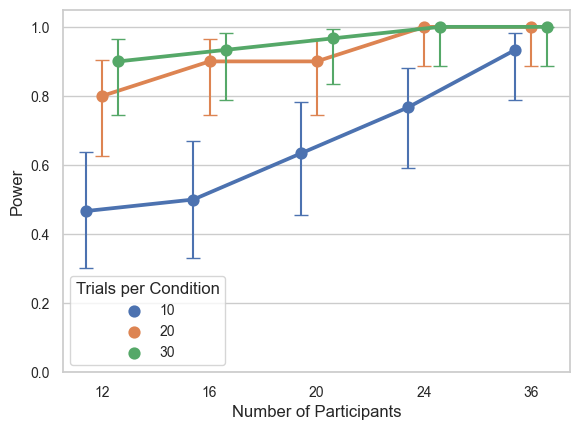

<Figure size 640x480 with 0 Axes>

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style and font sizes for publication
sns.set(style='whitegrid', font_scale=1.1)
plt.rcParams.update({
    'axes.titlesize': 13,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'legend.title_fontsize': 12
})

# Set up figure and axis
fig, ax = plt.subplots(figsize=(6, 4.5))  # Adjust size to fit journal layout

# Create the pointplot
sns_plot = sns.pointplot(
    data=summary,
    x='participants',
    y='mean_power',
    hue='trials_per_condition',
    errorbar=None,
    dodge=0.3,
    markers='o',
    ax=ax
)

# Get hue values and corresponding lines
hue_values = summary['trials_per_condition'].unique()
lines = sns_plot.lines

# Plot error bars with the same color as the markers
for line_idx, (line, hue_value) in enumerate(zip(lines, hue_values)):
    x_data = line.get_xdata()
    y_data = line.get_ydata()
    color = line.get_color()

    for x, y, participant in zip(x_data, y_data, summary['participants'].unique()):
        row = summary[
            (summary['participants'] == participant) &
            (summary['trials_per_condition'] == hue_value)
        ].iloc[0]

        ax.errorbar(
            x=x,
            y=row['mean_power'],
            yerr=[[row['mean_power'] - row['ci_low']], [row['ci_upp'] - row['mean_power']]],
            fmt='none',
            capsize=5,
            color=color
        )

# Customize labels and legend
ax.set_ylabel('Power')
ax.set_xlabel('Number of Participants')
ax.set_ylim(0, 1.05)
ax.legend(title='Trials per Condition')

# Tidy up and show
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(output_path, "power.png"), dpi=300, bbox_inches="tight")